In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from pytorch_fid import fid_score
from torchmetrics.image.inception import InceptionScore
from torchvision import transforms
from PIL import Image
import torch
import pandas as pd

In [2]:
def normalize_images(input_dir, output_dir, target_range=(0, 1)):
    """
    Normalize images in the input directory and save them to the output directory.

    Args:
        input_dir (str): Directory containing images to normalize.
        output_dir (str): Directory to save normalized images.
        target_range (tuple): Range to normalize images, e.g., (0, 1) or (-1, 1).
    """
    os.makedirs(output_dir, exist_ok=True)

    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    input_path = os.path.join(root, file)
                    output_path = os.path.join(output_dir, file)

                    # Open and normalize image
                    img = Image.open(input_path).convert("RGB")
                    img_array = np.asarray(img).astype(np.float32)
                    img_normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min())

                    # Map to target range
                    img_normalized = img_normalized * (target_range[1] - target_range[0]) + target_range[0]
                    img_normalized = np.clip(img_normalized, target_range[0], target_range[1])

                    # Save the normalized image
                    img_out = Image.fromarray((img_normalized * 255).astype(np.uint8))
                    img_out.save(output_path)
                except Exception as e:
                    print(f"Error processing {file}: {e}")

calculate FID and IS for images sampled by all checkpoints.

In [3]:
# Directories
REAL_IMAGES_DIR = "./processed-datasets/eval_data"
GENERATED_IMAGES_ROOT = "/scratch/kyq5pg/MLIA_final/samples"
TEMP_REAL_DIR = "./processed-datasets/normalized_eval_data"
TEMP_GEN_DIR = "./processed-datasets/temp_normalized_samples"

In [4]:
# Function to Compute FID
def compute_fid(real_dir, gen_dir):
    return fid_score.calculate_fid_given_paths(
        [real_dir, gen_dir],
        batch_size=16,
        device="cuda:0",
        dims=2048  # Default InceptionV3 layer
    )

# Function to Compute IS
def compute_inception_score(gen_dir):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 255).byte())  # InceptionScore function from torchmetrics requires to Convert images back to uint8 [0, 255]
    ])
    images = []
    for file in os.listdir(gen_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(os.path.join(gen_dir, file)).convert("RGB")
            images.append(transform(img))
    images = torch.stack(images).to("cuda:0")
    inception = InceptionScore().to("cuda:0")  # Move the model to GPU
    
    # inception.update(images)
    # Split images into batches to avoid out of memory on cuda
    batch_size = 16
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        inception.update(batch)
        
    return inception.compute()

In [5]:
# Process Each Checkpoint Directory
results = []
checkpoints = sorted(os.listdir(GENERATED_IMAGES_ROOT), key=lambda x: int(x.split('-')[1]))
checkpoints

['model-1',
 'model-2',
 'model-3',
 'model-4',
 'model-5',
 'model-6',
 'model-7',
 'model-8',
 'model-9',
 'model-10',
 'model-11',
 'model-12',
 'model-13',
 'model-14',
 'model-15',
 'model-16',
 'model-17',
 'model-18',
 'model-19',
 'model-20',
 'model-21',
 'model-22',
 'model-23',
 'model-24',
 'model-25',
 'model-26',
 'model-27',
 'model-28',
 'model-29',
 'model-30',
 'model-31',
 'model-32',
 'model-33',
 'model-34',
 'model-35',
 'model-36',
 'model-37',
 'model-38',
 'model-39',
 'model-40',
 'model-41',
 'model-42',
 'model-43',
 'model-44',
 'model-45',
 'model-46',
 'model-47',
 'model-48',
 'model-49',
 'model-50',
 'model-51',
 'model-52',
 'model-53',
 'model-54',
 'model-55',
 'model-56',
 'model-57',
 'model-58',
 'model-59',
 'model-60',
 'model-61',
 'model-62',
 'model-63',
 'model-64',
 'model-65',
 'model-66',
 'model-67',
 'model-68',
 'model-69',
 'model-70',
 'model-71',
 'model-72',
 'model-73',
 'model-74',
 'model-75']

In [6]:
print("Normalizing real images...")
normalize_images(REAL_IMAGES_DIR, TEMP_REAL_DIR, target_range=(0, 1))
print("Real image normalization finished")

Normalizing real images...
Real image normalization finished


In [7]:
# Initialize variables to track the best FID and IS
best_fid = float('inf')
best_fid_checkpoint = None

best_is_mean = float('-inf')
best_is_checkpoint = None


# calculation of FID and IS for first 75 checkpoints
# so far, we only sampled images for first 75 checkpoints
for checkpoint in checkpoints[:75]:
    gen_dir = os.path.join(GENERATED_IMAGES_ROOT, checkpoint)
    temp_gen_dir = os.path.join(TEMP_GEN_DIR, checkpoint)

    print(f"Normalizing sampled images for checkpoint: {checkpoint}...")
    normalize_images(gen_dir, temp_gen_dir, target_range=(0, 1))
    print(f"Normalizing sampled images for checkpoint: {checkpoint} finished.")

    # Compute FID  ============================================================================
    print(f"Computing FID for checkpoint: {checkpoint}...")
    fid = compute_fid(TEMP_REAL_DIR, temp_gen_dir)
    print(f"Computing FID for checkpoint: {checkpoint} finished. FID: {fid}")
    
    # Check if this is the best FID
    if fid < best_fid:
        best_fid = fid
        best_fid_checkpoint = checkpoint
        
    # Compute IS ==============================================================================
    print(f"Computing IS score for checkpoint: {checkpoint}...")
    is_mean, is_std = compute_inception_score(temp_gen_dir)
    print(f"Computing IS score for checkpoint: {checkpoint} finished. IS Mean: {is_mean.item()}, IS Std: {is_std.item()}")

    # Check if this is the best IS mean
    if is_mean > best_is_mean:
        best_is_mean = is_mean
        best_is_checkpoint = checkpoint
        
        
    # Store results
    results.append({
        "Checkpoint": checkpoint,
        "FID": fid,
        "IS Mean": is_mean.item(),
        "IS Std": is_std.item()
    })
    
    
    
    # torch.cuda.synchronize()
    # torch.cuda.empty_cache()
    
# Print the best FID and IS
print(f"Best FID: {best_fid} at checkpoint {best_fid_checkpoint}")
print(f"Best IS Mean: {best_is_mean} at checkpoint {best_is_checkpoint}")

Normalizing sampled images for checkpoint: model-1...
Normalizing sampled images for checkpoint: model-1 finished.
Computing FID for checkpoint: model-1...


100%|██████████| 62/62 [00:01<00:00, 55.97it/s]


Computing FID for checkpoint: model-1 finished. FID: 401.606514517876
Computing IS score for checkpoint: model-1...


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Computing IS score for checkpoint: model-1 finished. IS Mean: 1.215438723564148, IS Std: 0.015452423132956028
Normalizing sampled images for checkpoint: model-2...
Normalizing sampled images for checkpoint: model-2 finished.
Computing FID for checkpoint: model-2...


100%|██████████| 62/62 [00:01<00:00, 53.98it/s]


Computing FID for checkpoint: model-2 finished. FID: 395.0912494061014
Computing IS score for checkpoint: model-2...
Computing IS score for checkpoint: model-2 finished. IS Mean: 1.3067169189453125, IS Std: 0.022318867966532707
Normalizing sampled images for checkpoint: model-3...
Normalizing sampled images for checkpoint: model-3 finished.
Computing FID for checkpoint: model-3...


100%|██████████| 62/62 [00:01<00:00, 55.37it/s]


Computing FID for checkpoint: model-3 finished. FID: 363.50669460980293
Computing IS score for checkpoint: model-3...
Computing IS score for checkpoint: model-3 finished. IS Mean: 1.4239343404769897, IS Std: 0.04167071729898453
Normalizing sampled images for checkpoint: model-4...
Normalizing sampled images for checkpoint: model-4 finished.
Computing FID for checkpoint: model-4...


100%|██████████| 62/62 [00:01<00:00, 54.79it/s]


Computing FID for checkpoint: model-4 finished. FID: 292.80262845314553
Computing IS score for checkpoint: model-4...
Computing IS score for checkpoint: model-4 finished. IS Mean: 2.113759994506836, IS Std: 0.13137787580490112
Normalizing sampled images for checkpoint: model-5...
Normalizing sampled images for checkpoint: model-5 finished.
Computing FID for checkpoint: model-5...


100%|██████████| 62/62 [00:01<00:00, 54.24it/s]


Computing FID for checkpoint: model-5 finished. FID: 244.0037387606903
Computing IS score for checkpoint: model-5...
Computing IS score for checkpoint: model-5 finished. IS Mean: 3.0399045944213867, IS Std: 0.20293033123016357
Normalizing sampled images for checkpoint: model-6...
Normalizing sampled images for checkpoint: model-6 finished.
Computing FID for checkpoint: model-6...


100%|██████████| 62/62 [00:01<00:00, 56.38it/s]


Computing FID for checkpoint: model-6 finished. FID: 212.8021711570747
Computing IS score for checkpoint: model-6...
Computing IS score for checkpoint: model-6 finished. IS Mean: 3.913860321044922, IS Std: 0.22954224050045013
Normalizing sampled images for checkpoint: model-7...
Normalizing sampled images for checkpoint: model-7 finished.
Computing FID for checkpoint: model-7...


100%|██████████| 62/62 [00:01<00:00, 55.12it/s]


Computing FID for checkpoint: model-7 finished. FID: 189.78550423827352
Computing IS score for checkpoint: model-7...
Computing IS score for checkpoint: model-7 finished. IS Mean: 4.37489652633667, IS Std: 0.4063294231891632
Normalizing sampled images for checkpoint: model-8...
Normalizing sampled images for checkpoint: model-8 finished.
Computing FID for checkpoint: model-8...


100%|██████████| 62/62 [00:01<00:00, 56.66it/s]


Computing FID for checkpoint: model-8 finished. FID: 180.2784449223154
Computing IS score for checkpoint: model-8...
Computing IS score for checkpoint: model-8 finished. IS Mean: 4.732387542724609, IS Std: 0.3007195293903351
Normalizing sampled images for checkpoint: model-9...
Normalizing sampled images for checkpoint: model-9 finished.
Computing FID for checkpoint: model-9...


100%|██████████| 62/62 [00:01<00:00, 56.93it/s]


Computing FID for checkpoint: model-9 finished. FID: 177.74376660544795
Computing IS score for checkpoint: model-9...
Computing IS score for checkpoint: model-9 finished. IS Mean: 5.145821571350098, IS Std: 0.4263087213039398
Normalizing sampled images for checkpoint: model-10...
Normalizing sampled images for checkpoint: model-10 finished.
Computing FID for checkpoint: model-10...


100%|██████████| 62/62 [00:01<00:00, 56.07it/s]


Computing FID for checkpoint: model-10 finished. FID: 176.86682892395677
Computing IS score for checkpoint: model-10...
Computing IS score for checkpoint: model-10 finished. IS Mean: 5.097708702087402, IS Std: 0.47863486409187317
Normalizing sampled images for checkpoint: model-11...
Normalizing sampled images for checkpoint: model-11 finished.
Computing FID for checkpoint: model-11...


100%|██████████| 62/62 [00:01<00:00, 55.99it/s]


Computing FID for checkpoint: model-11 finished. FID: 175.80114292831195
Computing IS score for checkpoint: model-11...
Computing IS score for checkpoint: model-11 finished. IS Mean: 5.275187969207764, IS Std: 0.49586221575737
Normalizing sampled images for checkpoint: model-12...
Normalizing sampled images for checkpoint: model-12 finished.
Computing FID for checkpoint: model-12...


100%|██████████| 62/62 [00:01<00:00, 56.72it/s]


Computing FID for checkpoint: model-12 finished. FID: 178.45232325549784
Computing IS score for checkpoint: model-12...
Computing IS score for checkpoint: model-12 finished. IS Mean: 5.1100287437438965, IS Std: 0.40359076857566833
Normalizing sampled images for checkpoint: model-13...
Normalizing sampled images for checkpoint: model-13 finished.
Computing FID for checkpoint: model-13...


100%|██████████| 62/62 [00:01<00:00, 55.97it/s]


Computing FID for checkpoint: model-13 finished. FID: 175.23017548067696
Computing IS score for checkpoint: model-13...
Computing IS score for checkpoint: model-13 finished. IS Mean: 5.1298651695251465, IS Std: 0.22369082272052765
Normalizing sampled images for checkpoint: model-14...
Normalizing sampled images for checkpoint: model-14 finished.
Computing FID for checkpoint: model-14...


100%|██████████| 62/62 [00:01<00:00, 54.41it/s]


Computing FID for checkpoint: model-14 finished. FID: 181.10882681310505
Computing IS score for checkpoint: model-14...
Computing IS score for checkpoint: model-14 finished. IS Mean: 5.2693610191345215, IS Std: 0.3899879455566406
Normalizing sampled images for checkpoint: model-15...
Normalizing sampled images for checkpoint: model-15 finished.
Computing FID for checkpoint: model-15...


100%|██████████| 62/62 [00:01<00:00, 56.24it/s]


Computing FID for checkpoint: model-15 finished. FID: 186.45078134046003
Computing IS score for checkpoint: model-15...
Computing IS score for checkpoint: model-15 finished. IS Mean: 5.015307426452637, IS Std: 0.4559888541698456
Normalizing sampled images for checkpoint: model-16...
Normalizing sampled images for checkpoint: model-16 finished.
Computing FID for checkpoint: model-16...


100%|██████████| 62/62 [00:01<00:00, 56.87it/s]


Computing FID for checkpoint: model-16 finished. FID: 185.90883665355744
Computing IS score for checkpoint: model-16...
Computing IS score for checkpoint: model-16 finished. IS Mean: 5.2284064292907715, IS Std: 0.618179202079773
Normalizing sampled images for checkpoint: model-17...
Normalizing sampled images for checkpoint: model-17 finished.
Computing FID for checkpoint: model-17...


100%|██████████| 63/63 [00:01<00:00, 53.37it/s]


Computing FID for checkpoint: model-17 finished. FID: 188.16219963670005
Computing IS score for checkpoint: model-17...
Computing IS score for checkpoint: model-17 finished. IS Mean: 5.169879913330078, IS Std: 0.44062647223472595
Normalizing sampled images for checkpoint: model-18...
Normalizing sampled images for checkpoint: model-18 finished.
Computing FID for checkpoint: model-18...


100%|██████████| 62/62 [00:01<00:00, 56.43it/s]


Computing FID for checkpoint: model-18 finished. FID: 181.91005630737789
Computing IS score for checkpoint: model-18...
Computing IS score for checkpoint: model-18 finished. IS Mean: 5.1373515129089355, IS Std: 0.3212042450904846
Normalizing sampled images for checkpoint: model-19...
Normalizing sampled images for checkpoint: model-19 finished.
Computing FID for checkpoint: model-19...


100%|██████████| 62/62 [00:01<00:00, 56.02it/s]


Computing FID for checkpoint: model-19 finished. FID: 180.64437950045487
Computing IS score for checkpoint: model-19...
Computing IS score for checkpoint: model-19 finished. IS Mean: 5.16333532333374, IS Std: 0.28202253580093384
Normalizing sampled images for checkpoint: model-20...
Normalizing sampled images for checkpoint: model-20 finished.
Computing FID for checkpoint: model-20...


100%|██████████| 62/62 [00:01<00:00, 55.41it/s]


Computing FID for checkpoint: model-20 finished. FID: 178.6286488155035
Computing IS score for checkpoint: model-20...
Computing IS score for checkpoint: model-20 finished. IS Mean: 5.211437702178955, IS Std: 0.34060797095298767
Normalizing sampled images for checkpoint: model-21...
Normalizing sampled images for checkpoint: model-21 finished.
Computing FID for checkpoint: model-21...


100%|██████████| 185/185 [00:03<00:00, 57.29it/s]


Computing FID for checkpoint: model-21 finished. FID: 178.0562812462416
Computing IS score for checkpoint: model-21...
Computing IS score for checkpoint: model-21 finished. IS Mean: 5.626406192779541, IS Std: 0.3392621576786041
Normalizing sampled images for checkpoint: model-22...
Normalizing sampled images for checkpoint: model-22 finished.
Computing FID for checkpoint: model-22...


100%|██████████| 63/63 [00:01<00:00, 53.46it/s]


Computing FID for checkpoint: model-22 finished. FID: 177.656607826445
Computing IS score for checkpoint: model-22...
Computing IS score for checkpoint: model-22 finished. IS Mean: 5.047730922698975, IS Std: 0.31656602025032043
Normalizing sampled images for checkpoint: model-23...
Normalizing sampled images for checkpoint: model-23 finished.
Computing FID for checkpoint: model-23...


100%|██████████| 315/315 [00:06<00:00, 48.39it/s]


Computing FID for checkpoint: model-23 finished. FID: 176.2437210420029
Computing IS score for checkpoint: model-23...
Computing IS score for checkpoint: model-23 finished. IS Mean: 5.4996185302734375, IS Std: 0.21606259047985077
Normalizing sampled images for checkpoint: model-24...
Normalizing sampled images for checkpoint: model-24 finished.
Computing FID for checkpoint: model-24...


100%|██████████| 62/62 [00:01<00:00, 54.00it/s]


Computing FID for checkpoint: model-24 finished. FID: 182.48680642189225
Computing IS score for checkpoint: model-24...
Computing IS score for checkpoint: model-24 finished. IS Mean: 5.29028844833374, IS Std: 0.3642822206020355
Normalizing sampled images for checkpoint: model-25...
Normalizing sampled images for checkpoint: model-25 finished.
Computing FID for checkpoint: model-25...


100%|██████████| 64/64 [00:01<00:00, 56.58it/s]


Computing FID for checkpoint: model-25 finished. FID: 186.38404449462598
Computing IS score for checkpoint: model-25...
Computing IS score for checkpoint: model-25 finished. IS Mean: 4.91082239151001, IS Std: 0.3013312518596649
Normalizing sampled images for checkpoint: model-26...
Normalizing sampled images for checkpoint: model-26 finished.
Computing FID for checkpoint: model-26...


100%|██████████| 62/62 [00:01<00:00, 54.52it/s]


Computing FID for checkpoint: model-26 finished. FID: 183.8871969599653
Computing IS score for checkpoint: model-26...
Computing IS score for checkpoint: model-26 finished. IS Mean: 5.217811107635498, IS Std: 0.35645511746406555
Normalizing sampled images for checkpoint: model-27...
Normalizing sampled images for checkpoint: model-27 finished.
Computing FID for checkpoint: model-27...


100%|██████████| 62/62 [00:01<00:00, 55.71it/s]


Computing FID for checkpoint: model-27 finished. FID: 187.32811352622176
Computing IS score for checkpoint: model-27...
Computing IS score for checkpoint: model-27 finished. IS Mean: 5.061154842376709, IS Std: 0.3063918948173523
Normalizing sampled images for checkpoint: model-28...
Normalizing sampled images for checkpoint: model-28 finished.
Computing FID for checkpoint: model-28...


100%|██████████| 62/62 [00:01<00:00, 54.26it/s]


Computing FID for checkpoint: model-28 finished. FID: 186.00383686486612
Computing IS score for checkpoint: model-28...
Computing IS score for checkpoint: model-28 finished. IS Mean: 4.951906681060791, IS Std: 0.2817106246948242
Normalizing sampled images for checkpoint: model-29...
Normalizing sampled images for checkpoint: model-29 finished.
Computing FID for checkpoint: model-29...


100%|██████████| 63/63 [00:01<00:00, 52.61it/s]


Computing FID for checkpoint: model-29 finished. FID: 186.17805381836394
Computing IS score for checkpoint: model-29...
Computing IS score for checkpoint: model-29 finished. IS Mean: 5.083845615386963, IS Std: 0.3530677556991577
Normalizing sampled images for checkpoint: model-30...
Normalizing sampled images for checkpoint: model-30 finished.
Computing FID for checkpoint: model-30...


100%|██████████| 62/62 [00:01<00:00, 53.35it/s]


Computing FID for checkpoint: model-30 finished. FID: 188.23042926318675
Computing IS score for checkpoint: model-30...
Computing IS score for checkpoint: model-30 finished. IS Mean: 4.9903178215026855, IS Std: 0.5433530211448669
Normalizing sampled images for checkpoint: model-31...
Normalizing sampled images for checkpoint: model-31 finished.
Computing FID for checkpoint: model-31...


100%|██████████| 64/64 [00:01<00:00, 57.25it/s]


Computing FID for checkpoint: model-31 finished. FID: 184.72751705736331
Computing IS score for checkpoint: model-31...
Computing IS score for checkpoint: model-31 finished. IS Mean: 5.1571221351623535, IS Std: 0.4188920259475708
Normalizing sampled images for checkpoint: model-32...
Normalizing sampled images for checkpoint: model-32 finished.
Computing FID for checkpoint: model-32...


100%|██████████| 62/62 [00:01<00:00, 56.98it/s]


Computing FID for checkpoint: model-32 finished. FID: 190.54466072154122
Computing IS score for checkpoint: model-32...
Computing IS score for checkpoint: model-32 finished. IS Mean: 4.9039626121521, IS Std: 0.25122418999671936
Normalizing sampled images for checkpoint: model-33...
Normalizing sampled images for checkpoint: model-33 finished.
Computing FID for checkpoint: model-33...


100%|██████████| 62/62 [00:01<00:00, 56.05it/s]


Computing FID for checkpoint: model-33 finished. FID: 185.68827459127493
Computing IS score for checkpoint: model-33...
Computing IS score for checkpoint: model-33 finished. IS Mean: 4.905106544494629, IS Std: 0.32310256361961365
Normalizing sampled images for checkpoint: model-34...
Normalizing sampled images for checkpoint: model-34 finished.
Computing FID for checkpoint: model-34...


100%|██████████| 62/62 [00:01<00:00, 56.07it/s]


Computing FID for checkpoint: model-34 finished. FID: 188.36562453241817
Computing IS score for checkpoint: model-34...
Computing IS score for checkpoint: model-34 finished. IS Mean: 5.068593978881836, IS Std: 0.5843176245689392
Normalizing sampled images for checkpoint: model-35...
Normalizing sampled images for checkpoint: model-35 finished.
Computing FID for checkpoint: model-35...


100%|██████████| 62/62 [00:01<00:00, 56.56it/s]


Computing FID for checkpoint: model-35 finished. FID: 189.07057580803107
Computing IS score for checkpoint: model-35...
Computing IS score for checkpoint: model-35 finished. IS Mean: 5.043710231781006, IS Std: 0.3806909918785095
Normalizing sampled images for checkpoint: model-36...
Normalizing sampled images for checkpoint: model-36 finished.
Computing FID for checkpoint: model-36...


100%|██████████| 62/62 [00:01<00:00, 56.49it/s]


Computing FID for checkpoint: model-36 finished. FID: 189.86864548233544
Computing IS score for checkpoint: model-36...
Computing IS score for checkpoint: model-36 finished. IS Mean: 4.863544464111328, IS Std: 0.314456582069397
Normalizing sampled images for checkpoint: model-37...
Normalizing sampled images for checkpoint: model-37 finished.
Computing FID for checkpoint: model-37...


100%|██████████| 62/62 [00:01<00:00, 55.62it/s]


Computing FID for checkpoint: model-37 finished. FID: 187.64652378409886
Computing IS score for checkpoint: model-37...
Computing IS score for checkpoint: model-37 finished. IS Mean: 5.049757480621338, IS Std: 0.21112659573554993
Normalizing sampled images for checkpoint: model-38...
Normalizing sampled images for checkpoint: model-38 finished.
Computing FID for checkpoint: model-38...


100%|██████████| 62/62 [00:01<00:00, 53.96it/s]


Computing FID for checkpoint: model-38 finished. FID: 188.71987963986996
Computing IS score for checkpoint: model-38...
Computing IS score for checkpoint: model-38 finished. IS Mean: 4.922828674316406, IS Std: 0.25475114583969116
Normalizing sampled images for checkpoint: model-39...
Normalizing sampled images for checkpoint: model-39 finished.
Computing FID for checkpoint: model-39...


100%|██████████| 62/62 [00:01<00:00, 55.49it/s]


Computing FID for checkpoint: model-39 finished. FID: 190.9263888456087
Computing IS score for checkpoint: model-39...
Computing IS score for checkpoint: model-39 finished. IS Mean: 4.914784908294678, IS Std: 0.36470475792884827
Normalizing sampled images for checkpoint: model-40...
Normalizing sampled images for checkpoint: model-40 finished.
Computing FID for checkpoint: model-40...


100%|██████████| 62/62 [00:01<00:00, 56.10it/s]


Computing FID for checkpoint: model-40 finished. FID: 191.24890700431
Computing IS score for checkpoint: model-40...
Computing IS score for checkpoint: model-40 finished. IS Mean: 4.907064914703369, IS Std: 0.39631086587905884
Normalizing sampled images for checkpoint: model-41...
Normalizing sampled images for checkpoint: model-41 finished.
Computing FID for checkpoint: model-41...


100%|██████████| 62/62 [00:01<00:00, 54.00it/s]


Computing FID for checkpoint: model-41 finished. FID: 189.9575099608657
Computing IS score for checkpoint: model-41...
Computing IS score for checkpoint: model-41 finished. IS Mean: 4.768496990203857, IS Std: 0.3428822457790375
Normalizing sampled images for checkpoint: model-42...
Normalizing sampled images for checkpoint: model-42 finished.
Computing FID for checkpoint: model-42...


100%|██████████| 62/62 [00:01<00:00, 56.53it/s]


Computing FID for checkpoint: model-42 finished. FID: 192.31004023717483
Computing IS score for checkpoint: model-42...
Computing IS score for checkpoint: model-42 finished. IS Mean: 4.765057563781738, IS Std: 0.33567601442337036
Normalizing sampled images for checkpoint: model-43...
Normalizing sampled images for checkpoint: model-43 finished.
Computing FID for checkpoint: model-43...


100%|██████████| 62/62 [00:01<00:00, 56.65it/s]


Computing FID for checkpoint: model-43 finished. FID: 189.30101256001836
Computing IS score for checkpoint: model-43...
Computing IS score for checkpoint: model-43 finished. IS Mean: 4.697276592254639, IS Std: 0.5133305191993713
Normalizing sampled images for checkpoint: model-44...
Normalizing sampled images for checkpoint: model-44 finished.
Computing FID for checkpoint: model-44...


100%|██████████| 62/62 [00:01<00:00, 56.15it/s]


Computing FID for checkpoint: model-44 finished. FID: 189.07540976996432
Computing IS score for checkpoint: model-44...
Computing IS score for checkpoint: model-44 finished. IS Mean: 4.992076396942139, IS Std: 0.3522062599658966
Normalizing sampled images for checkpoint: model-45...
Normalizing sampled images for checkpoint: model-45 finished.
Computing FID for checkpoint: model-45...


100%|██████████| 62/62 [00:01<00:00, 55.91it/s]


Computing FID for checkpoint: model-45 finished. FID: 191.52354232135474
Computing IS score for checkpoint: model-45...
Computing IS score for checkpoint: model-45 finished. IS Mean: 4.955679416656494, IS Std: 0.39701783657073975
Normalizing sampled images for checkpoint: model-46...
Normalizing sampled images for checkpoint: model-46 finished.
Computing FID for checkpoint: model-46...


100%|██████████| 62/62 [00:01<00:00, 56.64it/s]


Computing FID for checkpoint: model-46 finished. FID: 191.9256257349213
Computing IS score for checkpoint: model-46...
Computing IS score for checkpoint: model-46 finished. IS Mean: 4.88409423828125, IS Std: 0.3179902732372284
Normalizing sampled images for checkpoint: model-47...
Normalizing sampled images for checkpoint: model-47 finished.
Computing FID for checkpoint: model-47...


100%|██████████| 62/62 [00:01<00:00, 56.06it/s]


Computing FID for checkpoint: model-47 finished. FID: 188.95254476974156
Computing IS score for checkpoint: model-47...
Computing IS score for checkpoint: model-47 finished. IS Mean: 4.967533111572266, IS Std: 0.5012539029121399
Normalizing sampled images for checkpoint: model-48...
Normalizing sampled images for checkpoint: model-48 finished.
Computing FID for checkpoint: model-48...


100%|██████████| 62/62 [00:01<00:00, 55.80it/s]


Computing FID for checkpoint: model-48 finished. FID: 190.7957808997504
Computing IS score for checkpoint: model-48...
Computing IS score for checkpoint: model-48 finished. IS Mean: 4.819798469543457, IS Std: 0.35836130380630493
Normalizing sampled images for checkpoint: model-49...
Normalizing sampled images for checkpoint: model-49 finished.
Computing FID for checkpoint: model-49...


100%|██████████| 62/62 [00:01<00:00, 55.86it/s]


Computing FID for checkpoint: model-49 finished. FID: 193.2330977129375
Computing IS score for checkpoint: model-49...
Computing IS score for checkpoint: model-49 finished. IS Mean: 4.682799816131592, IS Std: 0.3685115873813629
Normalizing sampled images for checkpoint: model-50...
Normalizing sampled images for checkpoint: model-50 finished.
Computing FID for checkpoint: model-50...


100%|██████████| 62/62 [00:01<00:00, 56.38it/s]


Computing FID for checkpoint: model-50 finished. FID: 194.4345994900607
Computing IS score for checkpoint: model-50...
Computing IS score for checkpoint: model-50 finished. IS Mean: 4.837496757507324, IS Std: 0.41563794016838074
Normalizing sampled images for checkpoint: model-51...
Normalizing sampled images for checkpoint: model-51 finished.
Computing FID for checkpoint: model-51...


100%|██████████| 62/62 [00:01<00:00, 54.80it/s]


Computing FID for checkpoint: model-51 finished. FID: 193.88722156516974
Computing IS score for checkpoint: model-51...
Computing IS score for checkpoint: model-51 finished. IS Mean: 4.646248817443848, IS Std: 0.35965821146965027
Normalizing sampled images for checkpoint: model-52...
Normalizing sampled images for checkpoint: model-52 finished.
Computing FID for checkpoint: model-52...


100%|██████████| 62/62 [00:01<00:00, 56.42it/s]


Computing FID for checkpoint: model-52 finished. FID: 192.65309773315172
Computing IS score for checkpoint: model-52...
Computing IS score for checkpoint: model-52 finished. IS Mean: 4.708693027496338, IS Std: 0.35887235403060913
Normalizing sampled images for checkpoint: model-53...
Normalizing sampled images for checkpoint: model-53 finished.
Computing FID for checkpoint: model-53...


100%|██████████| 62/62 [00:01<00:00, 55.99it/s]


Computing FID for checkpoint: model-53 finished. FID: 192.8718666481104
Computing IS score for checkpoint: model-53...
Computing IS score for checkpoint: model-53 finished. IS Mean: 5.070485591888428, IS Std: 0.29879170656204224
Normalizing sampled images for checkpoint: model-54...
Normalizing sampled images for checkpoint: model-54 finished.
Computing FID for checkpoint: model-54...


100%|██████████| 62/62 [00:01<00:00, 56.74it/s]


Computing FID for checkpoint: model-54 finished. FID: 193.8629273814494
Computing IS score for checkpoint: model-54...
Computing IS score for checkpoint: model-54 finished. IS Mean: 4.9350409507751465, IS Std: 0.5642370581626892
Normalizing sampled images for checkpoint: model-55...
Normalizing sampled images for checkpoint: model-55 finished.
Computing FID for checkpoint: model-55...


100%|██████████| 62/62 [00:01<00:00, 54.86it/s]


Computing FID for checkpoint: model-55 finished. FID: 196.48550748167753
Computing IS score for checkpoint: model-55...
Computing IS score for checkpoint: model-55 finished. IS Mean: 4.847236633300781, IS Std: 0.44345518946647644
Normalizing sampled images for checkpoint: model-56...
Normalizing sampled images for checkpoint: model-56 finished.
Computing FID for checkpoint: model-56...


100%|██████████| 62/62 [00:01<00:00, 56.13it/s]


Computing FID for checkpoint: model-56 finished. FID: 194.89612542586687
Computing IS score for checkpoint: model-56...
Computing IS score for checkpoint: model-56 finished. IS Mean: 4.939633846282959, IS Std: 0.46633821725845337
Normalizing sampled images for checkpoint: model-57...
Normalizing sampled images for checkpoint: model-57 finished.
Computing FID for checkpoint: model-57...


100%|██████████| 62/62 [00:01<00:00, 54.14it/s]


Computing FID for checkpoint: model-57 finished. FID: 191.8185252547343
Computing IS score for checkpoint: model-57...
Computing IS score for checkpoint: model-57 finished. IS Mean: 4.660759925842285, IS Std: 0.2966683506965637
Normalizing sampled images for checkpoint: model-58...
Normalizing sampled images for checkpoint: model-58 finished.
Computing FID for checkpoint: model-58...


100%|██████████| 62/62 [00:01<00:00, 56.56it/s]


Computing FID for checkpoint: model-58 finished. FID: 191.1319036955964
Computing IS score for checkpoint: model-58...
Computing IS score for checkpoint: model-58 finished. IS Mean: 4.728433132171631, IS Std: 0.3055371046066284
Normalizing sampled images for checkpoint: model-59...
Normalizing sampled images for checkpoint: model-59 finished.
Computing FID for checkpoint: model-59...


100%|██████████| 62/62 [00:01<00:00, 57.20it/s]


Computing FID for checkpoint: model-59 finished. FID: 191.70300504305368
Computing IS score for checkpoint: model-59...
Computing IS score for checkpoint: model-59 finished. IS Mean: 4.991382598876953, IS Std: 0.43621551990509033
Normalizing sampled images for checkpoint: model-60...
Normalizing sampled images for checkpoint: model-60 finished.
Computing FID for checkpoint: model-60...


100%|██████████| 64/64 [00:01<00:00, 57.51it/s]


Computing FID for checkpoint: model-60 finished. FID: 193.46716218307122
Computing IS score for checkpoint: model-60...
Computing IS score for checkpoint: model-60 finished. IS Mean: 4.6382317543029785, IS Std: 0.32469427585601807
Normalizing sampled images for checkpoint: model-61...
Normalizing sampled images for checkpoint: model-61 finished.
Computing FID for checkpoint: model-61...


100%|██████████| 63/63 [00:01<00:00, 53.97it/s]


Computing FID for checkpoint: model-61 finished. FID: 192.8281373057004
Computing IS score for checkpoint: model-61...
Computing IS score for checkpoint: model-61 finished. IS Mean: 5.092278003692627, IS Std: 0.45612767338752747
Normalizing sampled images for checkpoint: model-62...
Normalizing sampled images for checkpoint: model-62 finished.
Computing FID for checkpoint: model-62...


100%|██████████| 62/62 [00:01<00:00, 57.17it/s]


Computing FID for checkpoint: model-62 finished. FID: 194.16751732677136
Computing IS score for checkpoint: model-62...
Computing IS score for checkpoint: model-62 finished. IS Mean: 4.721078395843506, IS Std: 0.29387611150741577
Normalizing sampled images for checkpoint: model-63...
Normalizing sampled images for checkpoint: model-63 finished.
Computing FID for checkpoint: model-63...


100%|██████████| 62/62 [00:01<00:00, 55.90it/s]


Computing FID for checkpoint: model-63 finished. FID: 193.318892890352
Computing IS score for checkpoint: model-63...
Computing IS score for checkpoint: model-63 finished. IS Mean: 4.837693691253662, IS Std: 0.407164990901947
Normalizing sampled images for checkpoint: model-64...
Normalizing sampled images for checkpoint: model-64 finished.
Computing FID for checkpoint: model-64...


100%|██████████| 62/62 [00:01<00:00, 54.68it/s]


Computing FID for checkpoint: model-64 finished. FID: 195.94594244792296
Computing IS score for checkpoint: model-64...
Computing IS score for checkpoint: model-64 finished. IS Mean: 4.710936069488525, IS Std: 0.4009895622730255
Normalizing sampled images for checkpoint: model-65...
Normalizing sampled images for checkpoint: model-65 finished.
Computing FID for checkpoint: model-65...


100%|██████████| 62/62 [00:01<00:00, 57.32it/s]


Computing FID for checkpoint: model-65 finished. FID: 193.94759469675796
Computing IS score for checkpoint: model-65...
Computing IS score for checkpoint: model-65 finished. IS Mean: 4.73931360244751, IS Std: 0.278671532869339
Normalizing sampled images for checkpoint: model-66...
Normalizing sampled images for checkpoint: model-66 finished.
Computing FID for checkpoint: model-66...


100%|██████████| 62/62 [00:01<00:00, 56.05it/s]


Computing FID for checkpoint: model-66 finished. FID: 196.03676537383342
Computing IS score for checkpoint: model-66...
Computing IS score for checkpoint: model-66 finished. IS Mean: 4.807657718658447, IS Std: 0.3545779883861542
Normalizing sampled images for checkpoint: model-67...
Normalizing sampled images for checkpoint: model-67 finished.
Computing FID for checkpoint: model-67...


100%|██████████| 62/62 [00:01<00:00, 56.76it/s]


Computing FID for checkpoint: model-67 finished. FID: 197.13703376959603
Computing IS score for checkpoint: model-67...
Computing IS score for checkpoint: model-67 finished. IS Mean: 4.9029364585876465, IS Std: 0.2874477505683899
Normalizing sampled images for checkpoint: model-68...
Normalizing sampled images for checkpoint: model-68 finished.
Computing FID for checkpoint: model-68...


100%|██████████| 62/62 [00:01<00:00, 55.96it/s]


Computing FID for checkpoint: model-68 finished. FID: 190.6680425835176
Computing IS score for checkpoint: model-68...
Computing IS score for checkpoint: model-68 finished. IS Mean: 4.705914497375488, IS Std: 0.3568669557571411
Normalizing sampled images for checkpoint: model-69...
Normalizing sampled images for checkpoint: model-69 finished.
Computing FID for checkpoint: model-69...


100%|██████████| 62/62 [00:01<00:00, 55.34it/s]


Computing FID for checkpoint: model-69 finished. FID: 193.58604071960843
Computing IS score for checkpoint: model-69...
Computing IS score for checkpoint: model-69 finished. IS Mean: 4.99850606918335, IS Std: 0.4846791923046112
Normalizing sampled images for checkpoint: model-70...
Normalizing sampled images for checkpoint: model-70 finished.
Computing FID for checkpoint: model-70...


100%|██████████| 62/62 [00:01<00:00, 56.62it/s]


Computing FID for checkpoint: model-70 finished. FID: 195.175902098052
Computing IS score for checkpoint: model-70...
Computing IS score for checkpoint: model-70 finished. IS Mean: 4.57427978515625, IS Std: 0.3811006546020508
Normalizing sampled images for checkpoint: model-71...
Normalizing sampled images for checkpoint: model-71 finished.
Computing FID for checkpoint: model-71...


100%|██████████| 62/62 [00:01<00:00, 55.49it/s]


Computing FID for checkpoint: model-71 finished. FID: 194.84045459860542
Computing IS score for checkpoint: model-71...
Computing IS score for checkpoint: model-71 finished. IS Mean: 4.868216037750244, IS Std: 0.39128977060317993
Normalizing sampled images for checkpoint: model-72...
Normalizing sampled images for checkpoint: model-72 finished.
Computing FID for checkpoint: model-72...


100%|██████████| 62/62 [00:01<00:00, 56.66it/s]


Computing FID for checkpoint: model-72 finished. FID: 196.99796421739245
Computing IS score for checkpoint: model-72...
Computing IS score for checkpoint: model-72 finished. IS Mean: 4.631096363067627, IS Std: 0.2623896896839142
Normalizing sampled images for checkpoint: model-73...
Normalizing sampled images for checkpoint: model-73 finished.
Computing FID for checkpoint: model-73...


100%|██████████| 62/62 [00:01<00:00, 56.31it/s]


Computing FID for checkpoint: model-73 finished. FID: 196.76553164295535
Computing IS score for checkpoint: model-73...
Computing IS score for checkpoint: model-73 finished. IS Mean: 4.835473537445068, IS Std: 0.4050947427749634
Normalizing sampled images for checkpoint: model-74...
Normalizing sampled images for checkpoint: model-74 finished.
Computing FID for checkpoint: model-74...


100%|██████████| 62/62 [00:01<00:00, 57.04it/s]


Computing FID for checkpoint: model-74 finished. FID: 197.60173798840802
Computing IS score for checkpoint: model-74...
Computing IS score for checkpoint: model-74 finished. IS Mean: 4.701485633850098, IS Std: 0.4236850440502167
Normalizing sampled images for checkpoint: model-75...
Normalizing sampled images for checkpoint: model-75 finished.
Computing FID for checkpoint: model-75...


100%|██████████| 65/65 [00:01<00:00, 53.37it/s]


Computing FID for checkpoint: model-75 finished. FID: 193.71594228097902
Computing IS score for checkpoint: model-75...
Computing IS score for checkpoint: model-75 finished. IS Mean: 5.203740119934082, IS Std: 0.3606451153755188
Best FID: 175.23017548067696 at checkpoint model-13
Best IS Mean: 5.626406192779541 at checkpoint model-21


In [8]:
# Save Results
results_df = pd.DataFrame(results)
results_df.to_csv("evaluation_results.csv", index=False)

# Create a DataFrame for the best FID and IS
best_scores_df = pd.DataFrame([
    {"Metric": "FID", "Checkpoint": best_fid_checkpoint, "Value": best_fid},
    {"Metric": "IS Mean", "Checkpoint": best_is_checkpoint, "Value": best_is_mean.item()}
])
# Save to a separate CSV
best_scores_df.to_csv("best_scores.csv", index=False)

Plots saved as FID_vs_TrainingSteps.png and IS_vs_TrainingSteps.png.


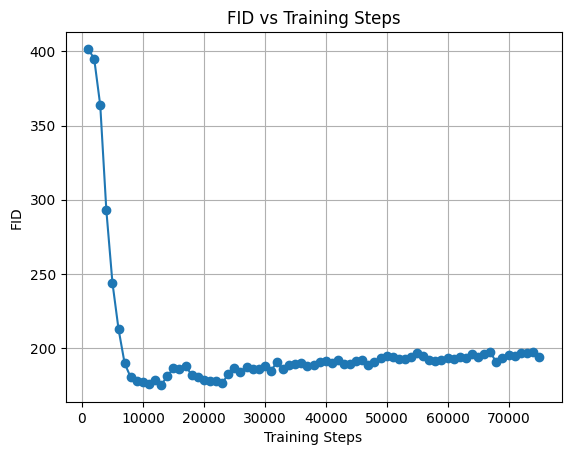

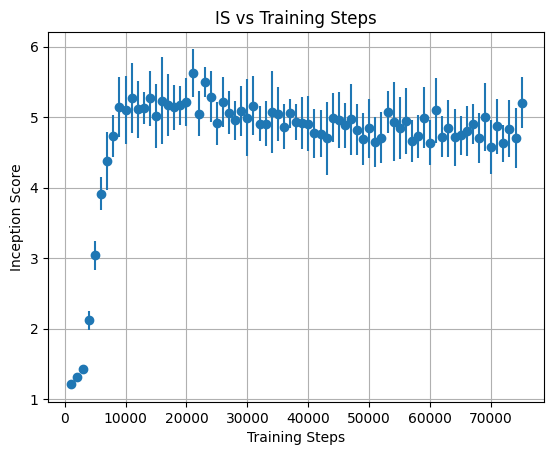

In [10]:
# Extract training steps from checkpoint names
results_df["Training Steps"] = results_df["Checkpoint"].apply(
    lambda x: int(x.split('-')[1]) * 1000 if x.startswith("model-") else None
)

# Drop rows without valid training steps (like Best FID/IS rows)
valid_results_df = results_df.dropna(subset=["Training Steps"])

# Plot FID vs Training Steps
plt.figure()
plt.plot(valid_results_df["Training Steps"], valid_results_df["FID"], marker='o')
plt.title("FID vs Training Steps")
plt.xlabel("Training Steps")
plt.ylabel("FID")
plt.grid()
plt.savefig("FID_vs_TrainingSteps.png")

# Plot IS vs Training Steps
plt.figure()
plt.errorbar(
    valid_results_df["Training Steps"], 
    valid_results_df["IS Mean"], 
    yerr=valid_results_df["IS Std"], 
    fmt='o'
)
plt.title("IS vs Training Steps")
plt.xlabel("Training Steps")
plt.ylabel("Inception Score")
plt.grid()
plt.savefig("IS_vs_TrainingSteps.png")

print("Plots saved as FID_vs_TrainingSteps.png and IS_vs_TrainingSteps.png.")

In [11]:
# Cleanup Temporary Directories
print("Cleaning up temporary directories...")
shutil.rmtree(TEMP_REAL_DIR, ignore_errors=True)
shutil.rmtree(TEMP_GEN_DIR, ignore_errors=True)

print("Evaluation completed. Results saved to 'evaluation_results.csv', 'FID_vs_Checkpoint.png', and 'IS_vs_Checkpoint.png'.")

Cleaning up temporary directories...
Evaluation completed. Results saved to 'evaluation_results.csv', 'FID_vs_Checkpoint.png', and 'IS_vs_Checkpoint.png'.


### Focus on the first 25000 training steps to plot

Plots saved as FID_vs_TrainingSteps_First25.png and IS_vs_TrainingSteps_First25.png.


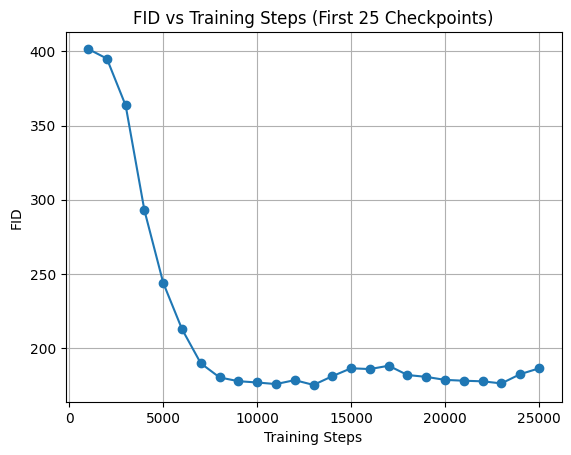

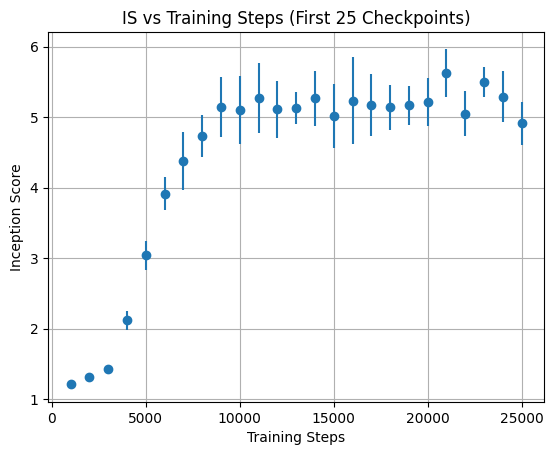

In [12]:
# Filter for the first 25 model checkpoints (<= 25,000 steps)
first_25_df = valid_results_df[valid_results_df["Training Steps"] <= 25000]

# Plot FID vs Training Steps for the first 25 checkpoints
plt.figure()
plt.plot(first_25_df["Training Steps"], first_25_df["FID"], marker='o')
plt.title("FID vs Training Steps (First 25 Checkpoints)")
plt.xlabel("Training Steps")
plt.ylabel("FID")
plt.grid()
plt.savefig("FID_vs_TrainingSteps_First25.png")

# Plot IS vs Training Steps for the first 25 checkpoints
plt.figure()
plt.errorbar(
    first_25_df["Training Steps"], 
    first_25_df["IS Mean"], 
    yerr=first_25_df["IS Std"], 
    fmt='o'
)
plt.title("IS vs Training Steps (First 25 Checkpoints)")
plt.xlabel("Training Steps")
plt.ylabel("Inception Score")
plt.grid()
plt.savefig("IS_vs_TrainingSteps_First25.png")

print("Plots saved as FID_vs_TrainingSteps_First25.png and IS_vs_TrainingSteps_First25.png.")